## 📝 Instruction
1. **Mount the Calibration Plate:** Secure the calibration plate at the designated location on the robot.
2. **Set the robot IP address:** In the box below set the robot IP address.
3. **Run the Code:** Execute the code provided below.
4. **Position the Robot Head:**
   - At the beginning, you'll be prompted to confirm if the robot's head is touching the calibration plate.
   - Before doing this, ensure the motors are disabled.
   - Manually move the robot's head to the calibration plate and carefully position it so that it is properly seated inside the plate.
   - Once positioned correctly, enter `y` and press `Enter` to continue.
5. **Retrieve the Calibration Matrix:**
   - The program will then run, and upon completion, it will output the calibration matrix labeled as `T_cam_2_j4`.
   - Be sure to save this matrix for future use with the camera.
   - Any result under `1mm` average error is considered excellent.

In [1]:
robot_ip = "192.168.254.87" # robot ip address 

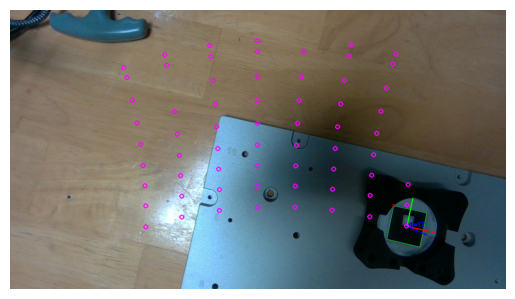

round:  72  /  72
avg error (mm):  1.0490012355849354
### calibration matrix ###
 [[0.003261876649460911, -0.9999942507546774, 0.0009048139903237413, 46.28838223380892], [0.9999890954829856, 0.0032649538338986625, -0.003344984535243112, 30.90870225580885], [0.0033420167330520264, -0.0009157150507125062, 0.999993996177028, -2.194882331603703], [0.0, 0.0, 0.0, 1.0]] 
##################


In [2]:
"""
necessary modules
"""
#%matplotlib widget
from dorna_vision import Detection, calibration
from camera import Camera
from dorna2 import Dorna
import numpy as np
import itertools

"""
System parameters
"""
robot_model = "dorna_ta" # robot model

"""
aruco board parameters
"""
aruco_id = 17 # detected marker
aruco_length= 24 # length in mm
aruco_dic="DICT_4X4_100" # aruco type
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False

# search area
joint_deviation = []
joint_deviation += list(itertools.product([-20, -15, -10, -5, 0, 5, 10, 15], [0], [0], [0], [-32, -30, -25, -20, -15, -10, -5, 0, 5],[0]))
joint_deviation = np.array(joint_deviation)

# collected data
collected_data = []

# camera
camera = Camera()

# Robot
robot = Dorna()

for _ in range(1):
    if not camera.connect():
        print("can not connect to camera")
        break

    if not robot.connect(robot_ip):
        print("can not connect to robot")
        break

    print("camera connected")
    print("robot connected")
    # detection
    prm = {'detection': {'cmd': 'aruco', 'dictionary': aruco_dic, 'marker_length': aruco_length, 'refine': aruco_refine, 'subpix': aruco_subpix}}
    detection = Detection(camera=camera, robot=None, **prm)

    # update collected data
    collected_data.append(calibration.dorna_ta_eye_in_hand_camera_kit(robot, detection, joint_deviation, aruco_id))  

    # ground truth
    gt = collected_data[0][0]["t_target_2_base"]

    # transformation matrix
    T_cam_2_j4 = calibration.minimizer(collected_data, robot.kinematic , use_aruco = False, use_ground_truth= True)
    
    # print result
    print("### calibration matrix ###\n",np.matrix.tolist(T_cam_2_j4), "\n##################")

    # close the connections
    camera.close()
    robot.close()


## Save the calibration matrix

In [3]:
# save data
robot.config["camera_mount"] = {"type":"dorna_ta_j4", "T": np.matrix.tolist(T_cam_2_j4)}
robot.dump_json(robot.config, "config.json")